In [ ]:
#| default_exp lcssm
import matplotlib.pyplot as plt

# Log-Concave State Space Models

A log-concave state space model is a partially gaussian state space model where the distribution of states $X_t$ is gaussian, but the (conditional) distribution of observations $Y_t$ is non-gaussian, but log-concave in signals $S_t = B_tX_t$ for a matrix $B_t$.

That is we consider 

$$
\begin{align*}
    X_0 &\sim \mathcal N(x_0, \Sigma_0)\\
    X_{t + 1} &= A_t X_t + \varepsilon_{t + 1}\\
    \varepsilon_{t} &\sim \mathcal N(0, \Sigma_t)\\
    Y_t | X_t &\sim Y_t | S_t \sim p(y_t|s_t)
\end{align*}
$$
where the conditional density $p(y_t|s_t)$ is **log-concave**, i.e. $\log p(y_t|s_t)$ is concave in $s_t$. 


::: {.callout-note}
# Implementation Detail
> dependency on parameters

To facilitate faster evaluation we split the implementation of $p(y_t|s_t)$ into two steps: 
- given $s_t$ compute a Pytree of parameters $\xi_t(s_t)$ 
- given $\xi_t$ compute $p(y_t|s_t)$

The first step allows for vectorization which we want to do as much as possible outside of the `tfd` calls.

As an example consider the univariate example of a negative binomial distribution with $\log$ link and constant overdispersion parameter $r$, i.e. $Y_t | X_t \text{NegBinom}(\mu = \exp(X_t), r)$. In this case $S_t = X_t$ and $\xi_t(s_t) = (r, s_t)$.
:::

## Simulation

As the states are gaussian, we can first simulate the states $X$ and then, conditional on them, calculate $S$ and $\xi$.

In [ ]:
#| export

from isssm.glssm import simulate_states
from jax import vmap
import jax.numpy as jnp
import jax.random as jrn

# matmul with $(A_t)_{t}$ and $(X_t)_{t}$
mm_time = vmap(jnp.matmul, (0, 0))
# matmul with $(A_t)_{t}$ and $(X^i_t)_{i,t}$
mm_time_sim = vmap(mm_time, (None, 0))
def v_time(xi_fun):
    """Vectorized xi function over time only

    Parameters
    ----------
    xi_fun : 
        the function to be vectorized

    Returns
    -------
    vxi_fun:
        vectorzied version of xi_fun
    """
    return vmap(xi_fun, (0,0))

def v_sample(xi_fun):
    """Vectorized xi function over samples only

    Parameters
    ----------
    xi_fun : 
        the function to be vectorized

    Returns
    -------
    vxi_fun:
        vectorzied version of xi_fun
    """
    return vmap(xi_fun, (None, 0))

def simulate_lcssm(x0, A, Sigma, B, xi_fun, dist, N, key):
    key, subkey = jrn.split(key)
    X = simulate_states(x0, A, Sigma, N, subkey)
    S = mm_time_sim(B, X)
    
    n, m, _ = A.shape

    vxi = v_sample(v_time(xi_fun))
    params = vxi(jnp.arange(n + 1), S)
    key, subkey = jrn.split(key)
    Y = dist(params).sample(seed=subkey)

    return X, Y

## Negative Binomial Common Factor Model

As an example consider a variant of the [common factor model](01_example_models.ipynb) where observations now follow a conditional negative binomial distribution, i.e. $Y_t^i \sim \text{NegBinom}(\mu = \exp((BX_t)_i), r)$ for $i = 1,2$.

In [ ]:
#| export
from tensorflow_probability.substrates.jax.distributions import NegativeBinomial as NBinom
def nb_lcssm(x0, A, Sigma, B, r):
    """Create a negative binomial common factor model

    Parameters
    ----------
    x0 : 
        initial state mean
    A : 
        state transition matrices
    Sigma : 
        innvovation covariances
    B : 
        signal matrix
    r :
        overdisperion parameter

    Returns
    -------
    lcssm:
        a negative binomial common factor model
    """
    r = jnp.atleast_1d(r)
    def xi_fun_nb(t, S):
        return (r, S)
    def dist_nb(params):
        r, log_mu = params
        mu = jnp.exp(log_mu)
        return NBinom(r, probs=mu/(r + mu))
        
    return x0, A, Sigma, B, xi_fun_nb, dist_nb

In [ ]:
m, p, n = 3, 2, 100
A = jnp.broadcast_to(jnp.eye(m), (n, m, m))
B = jnp.broadcast_to(jnp.array([[1, 0, 1], [0, 1, 1]]), (n + 1, p, m))

s2= 0.01
Sigma = jnp.broadcast_to(s2 * jnp.eye(m), (n + 1, m, m))
x0 = jnp.ones(m)

key = jrn.PRNGKey(512)
key, subkey = jrn.split(key)
*_, xi_fun, dist = nb_lcssm(x0, A, Sigma, B, 20.)
N = 1
(X, ), (Y,) = simulate_lcssm(x0, A, Sigma, B, xi_fun, dist, N, subkey)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


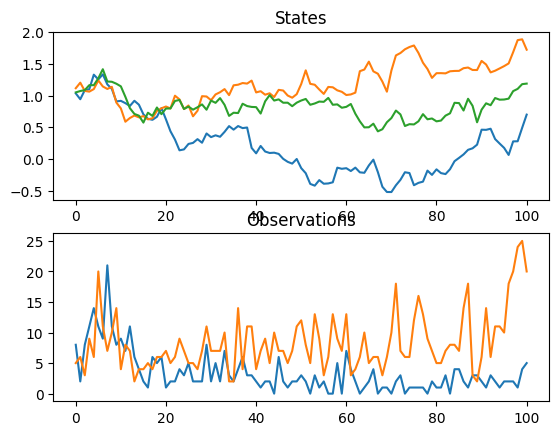

In [ ]:
fig, (ax1, ax2) = plt.subplots(2)

ax1.set_title("States")
ax2.set_title("Observations")

ax1.plot(X)
ax2.plot(Y)

plt.show()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()